<a href="https://colab.research.google.com/github/avkaz/DeepLearningPetIdentification/blob/baseline/baseline_exper.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This baseline model is designed to perform vector similarity search for a pet database. When a user uploads an image of a pet, the model checks whether a similar pet has been previously found. **EfficientNetB0**, a pre-trained convolutional neural network, is used to extract embeddings from images. **FAISS** enables efficient indexing and search of the result vectors. **Cosine similarity** and **L2 distance** are compared to select the best method for determining image similarity. The goal of the experiment is to evaluate these metrics' performance, with **recall** , **precision** , and **F1 score** used to assess the general model's accuracy.

imports:

In [29]:
## 1st -  Download utility.py file from github repository
## 2nd - Imports all functions from utility.py

import requests

# Correct raw URL for the utility.py file
url = "https://raw.githubusercontent.com/avkaz/DeepLearningPetIdentification/main/utility.py"

# Fetch and save the file locally
response = requests.get(url)
with open("utility.py", "wb") as f:
    f.write(response.content)


import utility
print("utility.py downloaded successfully.")

import tensorflow as tf

from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from io import BytesIO
import pandas as pd
from google.colab import files
!pip install faiss-gpu
from tensorflow.keras.applications import EfficientNetB0
import faiss

utility.py downloaded successfully.


data:

In [3]:
data = utility.get_data()
trypets = list(data.items())[:20]
#trypets

EfficientNetB0, pre-trained on ImageNet, is chosen for its strong performance and efficiency. With `include_top=False`, it focuses on embeddings extraction by excluding fully connected layers. Images need preprocessing to fit the model's input requirements for effective similarity comparison.

In [28]:
model = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg')

Postings with multiple pets are filtered out to ensure the dataset consists of single-pet entries for accurate similarity matching.

In [30]:
f_trypets = [
    pet for pet in trypets
    if not any(part.startswith('a') for part in pet[0].split('-')[1:])
]
#f_trypets

Below, embeddings for pet images are computed and compared using FAISS with L2 distance and cosine similarity. The embeddings are normalized and indexed for efficient retrieval. For each pet, the **top 5** nearest neighbors are retrieved using both similarity measures. The first picture retrieved is the test image, which shows a **low L2 distance and high cosine similarity** to itself. Performance is evaluated using **precision, recall, and F1 score** at k=5 for both similarity measures, with results displayed for each pet along with average metrics to assess overall performance.

In [6]:
# embeddings for FAISS
all_embeddings = []
all_pet_names = []
all_image_urls = []

for pet_id, pet_info in f_trypets:
    pet_name = pet_info['Jméno']
    for image_url in pet_info["images"]:
        embedding = utility.download_and_preprocess_image(image_url, target_size=(224, 224))
        if embedding is not None:
            all_embeddings.append(embedding.numpy().flatten())  # flatten
            all_pet_names.append(pet_name)
            all_image_urls.append(image_url)

all_embeddings = np.array(all_embeddings)

Uploading model...
Model loaded successfully.


In [36]:
# normalize embeddings
def normalize_embeddings(embeddings):
    norms = np.linalg.norm(embeddings, axis=1, keepdims=True)
    return embeddings / norms

normalized_embeddings = normalize_embeddings(all_embeddings)

# FAISS indexes
l2_index = faiss.IndexFlatL2(all_embeddings.shape[1])
cosine_similarity_index = faiss.IndexFlatIP(all_embeddings.shape[1])

# add embeddings to indexes
l2_index.add(all_embeddings)
cosine_similarity_index.add(normalized_embeddings)

# unique pet
unique_pet_indices = {name: idx for idx, name in enumerate(all_pet_names)}.values()

# main test fun
def test_pet_retrieval(test_embedding_index, k=5):
    test_embedding = all_embeddings[test_embedding_index:test_embedding_index + 1]
    test_embedding_normalized = normalized_embeddings[test_embedding_index:test_embedding_index + 1]

    l2_distances, l2_indices = l2_index.search(test_embedding, k)
    cosine_sim_scores, cosine_sim_indices = cosine_similarity_index.search(test_embedding_normalized, k)

    results = []
    for rank, (l2_dist, l2_idx, cos_sim_score, cos_sim_idx) in enumerate(
        zip(l2_distances[0], l2_indices[0], cosine_sim_scores[0], cosine_sim_indices[0]), start=1
    ):
        results.append({
            "Rank": rank,
            "Test_Pet": all_pet_names[test_embedding_index],
            "Matched_Pet_L2": all_pet_names[l2_idx],
            "Matched_Pet_Cosine": all_pet_names[cos_sim_idx],
            "L2_Distance": l2_dist,
            "Cosine_Similarity": cos_sim_score,
            "Image_URL_L2": all_image_urls[l2_idx],
            "Image_URL_Cosine": all_image_urls[cos_sim_idx],
        })

    return results

# metrics
def calculate_metrics(results, ground_truth, k):
    """
    calculate precision, recall, and F1 score at k.
    """
    top_k_results_cosine = [res["Matched_Pet_Cosine"] for res in results[:k]]
    top_k_results_l2 = [res["Matched_Pet_L2"] for res in results[:k]]

    relevant_results_cosine = [1 if pet == ground_truth else 0 for pet in top_k_results_cosine]
    relevant_results_l2 = [1 if pet == ground_truth else 0 for pet in top_k_results_l2]

    precision_cosine = sum(relevant_results_cosine) / k
    recall_cosine = sum(relevant_results_cosine) / 1  # Single ground truth assumption
    f1_cosine = (
        2 * precision_cosine * recall_cosine / (precision_cosine + recall_cosine)
        if (precision_cosine + recall_cosine) > 0 else 0
    )

    precision_l2 = sum(relevant_results_l2) / k
    recall_l2 = sum(relevant_results_l2) / 1
    f1_l2 = (
        2 * precision_l2 * recall_l2 / (precision_l2 + recall_l2)
        if (precision_l2 + recall_l2) > 0 else 0
    )

    return precision_cosine, recall_cosine, f1_cosine, precision_l2, recall_l2, f1_l2

# test
k = 5
metrics = {
    "Pet_Name": [],
    "Precision@5_Cosine": [],
    "Recall@5_Cosine": [],
    "F1@5_Cosine": [],
    "Precision@5_L2": [],
    "Recall@5_L2": [],
    "F1@5_L2": [],
}

for idx in unique_pet_indices:
    print(f"\nTested Pet: {all_pet_names[idx]}")
    results = test_pet_retrieval(idx)
    for res in results:
        print(res)

    ground_truth = all_pet_names[idx]
    precision_cosine, recall_cosine, f1_cosine, precision_l2, recall_l2, f1_l2 = calculate_metrics(results, ground_truth, k)

    metrics["Pet_Name"].append(ground_truth)
    metrics["Precision@5_Cosine"].append(precision_cosine)
    metrics["Recall@5_Cosine"].append(recall_cosine)
    metrics["F1@5_Cosine"].append(f1_cosine)
    metrics["Precision@5_L2"].append(precision_l2)
    metrics["Recall@5_L2"].append(recall_l2)
    metrics["F1@5_L2"].append(f1_l2)

    print(f"Cosine - Precision@5: {precision_cosine:.4f}, Recall@5: {recall_cosine:.4f}, F1@5: {f1_cosine:.4f}")
    print(f"L2 - Precision@5: {precision_l2:.4f}, Recall@5: {recall_l2:.4f}, F1@5: {f1_l2:.4f}")

# display res
df_metrics = pd.DataFrame(metrics)
print("\n=== Metrics per Pet ===")
print(df_metrics)


average_metrics = {
    "Metric": ["Precision@5_Cosine", "Recall@5_Cosine", "F1@5_Cosine", "Precision@5_L2", "Recall@5_L2", "F1@5_L2"],
    "Average": [
        np.mean(metrics["Precision@5_Cosine"]),
        np.mean(metrics["Recall@5_Cosine"]),
        np.mean(metrics["F1@5_Cosine"]),
        np.mean(metrics["Precision@5_L2"]),
        np.mean(metrics["Recall@5_L2"]),
        np.mean(metrics["F1@5_L2"]),
    ]
}
df_average_metrics = pd.DataFrame(average_metrics)
print("\n=== Average Metrics ===")
print(df_average_metrics)



Tested Pet: Tanyny
{'Rank': 1, 'Test_Pet': 'Tanyny', 'Matched_Pet_L2': 'Tanyny', 'Matched_Pet_Cosine': 'Tanyny', 'L2_Distance': 0.0, 'Cosine_Similarity': 0.9998541, 'Image_URL_L2': 'https://www.psidetektiv.cz/data/catalog/big/2024/12/22/img190394.jpg', 'Image_URL_Cosine': 'https://www.psidetektiv.cz/data/catalog/big/2024/12/22/img190394.jpg'}
{'Rank': 2, 'Test_Pet': 'Tanyny', 'Matched_Pet_L2': 'Želva', 'Matched_Pet_Cosine': 'Tanyny', 'L2_Distance': 7621.1436, 'Cosine_Similarity': 0.8709577, 'Image_URL_L2': 'https://www.psidetektiv.cz/data/catalog/big/2024/12/19/img190186.jpg', 'Image_URL_Cosine': 'https://www.psidetektiv.cz/data/catalog/big/2024/12/22/img190393.jpg'}
{'Rank': 3, 'Test_Pet': 'Tanyny', 'Matched_Pet_L2': 'Tanyny', 'Matched_Pet_Cosine': 'Tanyny', 'L2_Distance': 7742.9434, 'Cosine_Similarity': 0.8643462, 'Image_URL_L2': 'https://www.psidetektiv.cz/data/catalog/big/2024/12/22/img190391.jpg', 'Image_URL_Cosine': 'https://www.psidetektiv.cz/data/catalog/big/2024/12/22/img1903

The average metrics show that the **L2 distance** method outperforms **cosine similarity** across all measures. **Precision** for **L2** is **0.34**, indicating that, on average, **1.7** images of the correct pet were returned in the top 5 results, with 1 image always being the test pet itself. Given these results, the **L2 method** should be preferred. The model will be further fine-tuned.

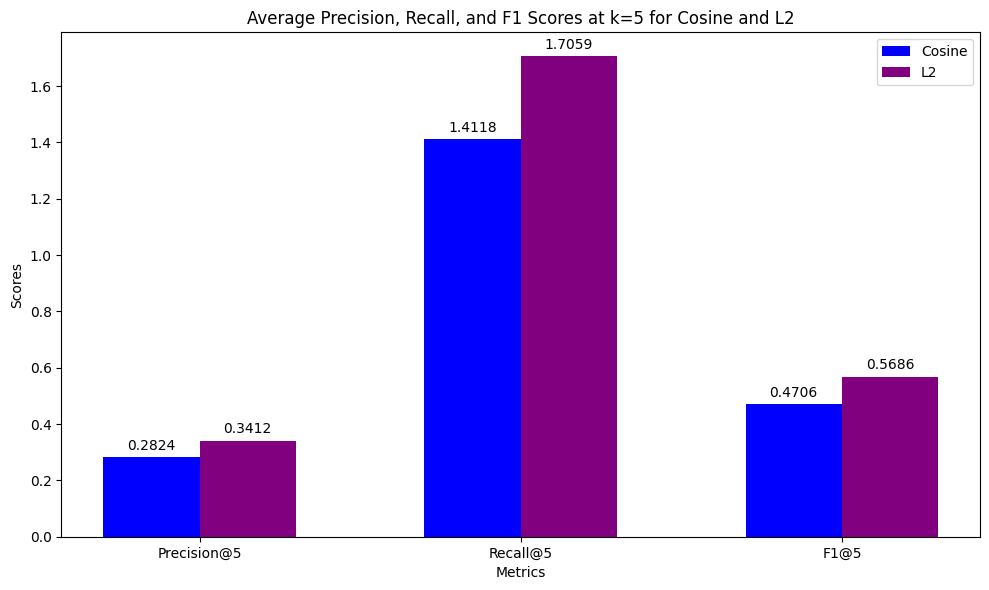

In [39]:
# data
metrics_labels = ['Precision@5', 'Recall@5', 'F1@5']
cosine_metrics = [
    np.mean(metrics["Precision@5_Cosine"]),
    np.mean(metrics["Recall@5_Cosine"]),
    np.mean(metrics["F1@5_Cosine"]),
]
l2_metrics = [
    np.mean(metrics["Precision@5_L2"]),
    np.mean(metrics["Recall@5_L2"]),
    np.mean(metrics["F1@5_L2"]),
]

# plot
x = np.arange(len(metrics_labels))
width = 0.3

fig, ax = plt.subplots(figsize=(10, 6))

cosine_color = 'blue'
l2_color = 'purple'

rects1 = ax.bar(x - width/2, cosine_metrics, width, label='Cosine', color=cosine_color)
rects2 = ax.bar(x + width/2, l2_metrics, width, label='L2', color=l2_color)

ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Average Precision, Recall, and F1 Scores at k=5 for Cosine and L2')
ax.set_xticks(x)
ax.set_xticklabels(metrics_labels)
ax.legend()

# values on bars
def add_values(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

add_values(rects1)
add_values(rects2)

plt.tight_layout()
plt.show()


The match is considered true if the test pet matches the identified pet in at least two instances.

In this comparison, **L2** achieved a true match in 10 out of 17 instances, while cosine similarity achieved a true match in only 5. The function `is_true_match_for_metric` checks whether the test pet appears at least twice in the top 5 retrieved results for each similarity metric. The `compare_metrics` function evaluates both **L2** and cosine matches for each pet and compares the results. A histogram is plotted to visually compare the true match counts for both **L2** and **cosine similarity**, with **L2** outperforming **cosine** in terms of true matches.

true matches:
   Test_Pet  L2_True_Match  Cosine_True_Match
0    Tanyny           True               True
1     Haily           True              False
2       Egy           True              False
3     Randy           True              False
4     Alfík          False               True
5     Juicy          False              False
6      Urri           True               True
7      Lily           True              False
8    Užovka          False              False
9      Endy           True               True
10     Gigy          False              False
11      Rey          False              False
12    Želva          False              False
13   Terina           True               True
14    Pedro           True              False
15      Ira           True              False
16    Adolf          False              False


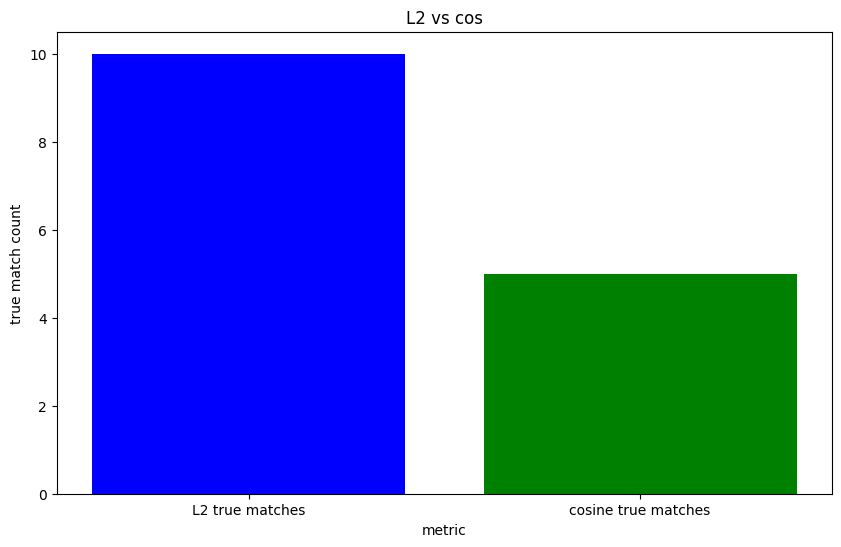

In [19]:
# check if match is true for a metric
def is_true_match_for_metric(matches, test_pet_name):
    return sum(1 for match in matches if match == test_pet_name) >= 2

# compare results for L2 and Cosine similarity
def compare_metrics(test_pet_idx, k=5):
    results = test_pet_retrieval(test_pet_idx, k)
    l2_matches = [result['Matched_Pet_L2'] for result in results]
    cos_matches = [result['Matched_Pet_Cosine'] for result in results]
    test_pet_name = all_pet_names[test_pet_idx]

    return {
        'Test_Pet': test_pet_name,
        'L2_Matches': l2_matches,
        'Cosine_Matches': cos_matches,
        'L2_True_Match': is_true_match_for_metric(l2_matches, test_pet_name),
        'Cosine_True_Match': is_true_match_for_metric(cos_matches, test_pet_name)
    }

# compare metrics for each pet
comparison_results = [compare_metrics(idx) for idx in unique_pet_indices]

# create DataFrame for results
def create_results_dataframe(comparison_results):
    return pd.DataFrame([{
        'Test_Pet': res['Test_Pet'],
        'L2_True_Match': res['L2_True_Match'],
        'Cosine_True_Match': res['Cosine_True_Match']
    } for res in comparison_results])

comparison_df = create_results_dataframe(comparison_results)

# display true matches
print("true matches:")
print(comparison_df)

# plot histogram for L2 vs Cosine true matches
plt.figure(figsize=(10, 6))
plt.bar(['L2 true matches', 'cosine true matches'], [
    comparison_df['L2_True_Match'].sum(),
    comparison_df['Cosine_True_Match'].sum()
], color=['blue', 'green'])

plt.xlabel('metric')
plt.ylabel('true match count')
plt.title('L2 vs cos')
plt.show()
